# Install necessary library

In [2]:
!pip install -U imbalanced-learn deap catboost scikit-learn --quiet

# Import Library

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Algorithms
from xgboost import XGBClassifier
from deap import base, creator, tools, algorithms
import random
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Preprocessing

In [4]:
df = pd.read_csv("Student Dropout data.csv", sep=';')
print("✅ File loaded successfully.")
df.isna().sum()
df

✅ File loaded successfully.


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [5]:
target_counts = df["Target"].value_counts()
print(target_counts)

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


Combine the non-dropout categories

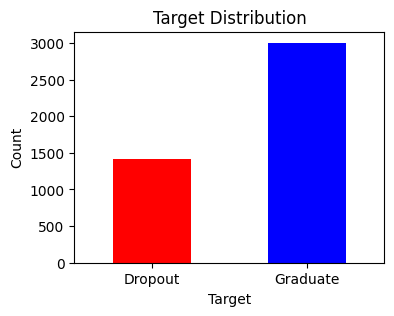

In [6]:
X = df.drop(columns=['Target'])
y = df['Target']
y = y.map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1}).astype(int)

plt.figure(figsize=(4, 3))
y.value_counts().sort_index().plot(kind='bar', color=['red', 'blue'])
plt.title("Target Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Dropout", "Graduate"], rotation=0)
plt.show()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Min-Max Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost

## Genetic Algorithm

In [77]:
# Define the fitness function
def evaluate_xgb(individual):
    params = {
        'max_depth': int(individual[0]),
        'learning_rate': max(individual[1], 0.001),
        'n_estimators': int(individual[2]),
        'min_child_weight': max(int(individual[3]), 1),
        'gamma': max(individual[4], 0),
        'subsample': max(min(individual[5], 1.0), 0.1),
        'colsample_bytree': max(min(individual[6], 1.0), 0.1),
    }

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', XGBClassifier(**params, random_state=42))
    ])

    scores = cross_val_score(
        pipeline,
        X_train_scaled,
        y_train,
        cv=3,
        scoring='accuracy'
    )
    return (np.mean(scores),)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 3, 10)           # max_depth
toolbox.register("attr_float", random.uniform, 0.01, 0.3)     # learning_rate
toolbox.register("attr_estimators", random.randint, 50, 200)  # n_estimators
toolbox.register("attr_child_weight", random.randint, 1, 10)  # min_child_weight
toolbox.register("attr_gamma", random.uniform, 0, 0.5)        # gamma
toolbox.register("attr_subsample", random.uniform, 0.5, 1.0)  # subsample
toolbox.register("attr_colsample", random.uniform, 0.5, 1.0)  # colsample_bytree

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_float, toolbox.attr_estimators,
                  toolbox.attr_child_weight, toolbox.attr_gamma,
                  toolbox.attr_subsample, toolbox.attr_colsample), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_xgb)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [78]:
population = toolbox.population(n=20)
hof = tools.HallOfFame(3)  # Save top 3 individuals
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

result, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=0.7, mutpb=0.2, ngen=10,
    stats=stats, halloffame=hof, verbose=True
)

# Get best parameters
best_params = {
    'max_depth': int(hof[0][0]),
    'learning_rate': hof[0][1],
    'n_estimators': int(hof[0][2]),
    'min_child_weight': int(hof[0][3]),
    'gamma': hof[0][4],
    'subsample': hof[0][5],
    'colsample_bytree': hof[0][6],
}

gen	nevals	avg    	min     	max     
0  	20    	0.86896	0.858527	0.876615
1  	18    	0.87114	0.859496	0.87823 
2  	12    	0.873353	0.864341	0.879522
3  	16    	0.874128	0.864664	0.879522
4  	19    	0.87647 	0.872416	0.879522
5  	17    	0.876001	0.857558	0.879522
6  	17    	0.877261	0.873708	0.879845
7  	15    	0.876244	0.865633	0.879845
8  	17    	0.878101	0.874354	0.879845
9  	14    	0.876631	0.864018	0.880491
10 	14    	0.876954	0.864018	0.879845


In [79]:
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 6, 'learning_rate': 0.049220955992711424, 'n_estimators': 150, 'min_child_weight': 1, 'gamma': 0.350459751166719, 'subsample': 0.6330286965303468, 'colsample_bytree': 0.5537086444753803}


In [80]:
best_XGB = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(**best_params))
])
best_XGB.fit(X_train_scaled, y_train)
print(classification_report(y_test, best_XGB.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       427
           1       0.89      0.92      0.91       901

    accuracy                           0.87      1328
   macro avg       0.86      0.84      0.85      1328
weighted avg       0.87      0.87      0.87      1328



## Store the best hyperparameter (so far) here

In [81]:
# Use this for the report

params_xgb = {'max_depth': 7,
              'learning_rate': 0.0624501362419474,
              'n_estimators': 111,
              'min_child_weight': 1,
              'gamma': 0.4712833060708306,
              'subsample': 0.9855205167609775,
              'colsample_bytree': 0.49626690033940724}

XGB_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(**params_xgb))
])

XGB_model.fit(X_train_scaled, y_train)

xgb_y_pred_train = XGB_model.predict(X_train_scaled)
xgb_y_pred = XGB_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, xgb_y_pred)
print ("XGBoost - Accuracy (Test Set):", accuracy_xgb)

XGBoost - Accuracy (Test Set): 0.8772590361445783


In [82]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       427
           1       0.89      0.93      0.91       901

    accuracy                           0.88      1328
   macro avg       0.87      0.85      0.86      1328
weighted avg       0.88      0.88      0.88      1328



Compare the metrics from label '0' (Dropout) with the previous paper result below

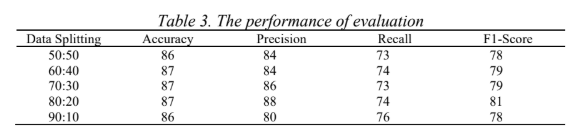

## Try default parameter here in case the result from genetic algorithm is not well optimized

In [118]:
XGB_model_default = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier())
])

XGB_model_default.fit(X_train_scaled, y_train)

xgb_y_pred_train = XGB_model_default.predict(X_train_scaled)
xgb_y_pred = XGB_model_default.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, xgb_y_pred)
print ("XGBoost - Accuracy (Test Set):", accuracy_xgb)

XGBoost - Accuracy (Test Set): 0.8637048192771084


In [119]:
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       427
           1       0.88      0.92      0.90       901

    accuracy                           0.86      1328
   macro avg       0.85      0.83      0.84      1328
weighted avg       0.86      0.86      0.86      1328



# Light GBM

## Genetic Algorithm

In [98]:
import warnings

# Just reference FutureWarning directly—no import needed
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the fitness function
def evaluate_lgbm(individual):
    params = {
        'max_depth': int(individual[0]),
        'learning_rate': max(individual[1], 0.001),
        'n_estimators': int(individual[2]),
        'min_child_weight': int(individual[3]),
        'num_leaves': 31,
        'subsample': max(min(individual[5], 1.0), 0.1),
        'colsample_bytree': max(min(individual[6], 1.0), 0.1),
        'min_split_gain': max(individual[4], 0),
        'min_sum_hessian_in_leaf': 1e-3,
        'objective': 'binary',
        'random_state': 42,
        'verbosity': -1
    }

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', lgb.LGBMClassifier(**params))
    ])

    scores = cross_val_score(
        pipeline,
        X_train_scaled,
        y_train,
        cv=3,
        scoring='accuracy'
    )
    return (np.mean(scores),)

# Define fitness and individual representation
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_max_depth", random.randint, 3, 10)               # Integer: tree depth
toolbox.register("attr_learning_rate", random.uniform, 0.01, 0.3)       # Float: learning rate
toolbox.register("attr_n_estimators", random.randint, 50, 200)          # Integer: number of trees
toolbox.register("attr_min_child_weight", random.randint, 1, 10)        # Integer: minimum child weight
toolbox.register("attr_split_gain", random.uniform, 0, 0.5)             # Float (ignored by LightGBM but preserved for consistency)
toolbox.register("attr_subsample", random.uniform, 0.5, 1.0)            # Float: subsample rate
toolbox.register("attr_colsample_bytree", random.uniform, 0.5, 1.0)     # Float: column subsample rate
toolbox.register("individual", tools.initCycle, creator.Individual, (
    toolbox.attr_max_depth,
    toolbox.attr_learning_rate,
    toolbox.attr_n_estimators,
    toolbox.attr_min_child_weight,
    toolbox.attr_split_gain,
    toolbox.attr_subsample,
    toolbox.attr_colsample_bytree,
), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_lgbm)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [108]:
population = toolbox.population(n=20)

hof = tools.HallOfFame(3)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

result, logbook = algorithms.eaSimple(
    population=population,
    toolbox=toolbox,
    cxpb=0.7,                # Crossover probability
    mutpb=0.2,               # Mutation probability
    ngen=10,                 # Number of generations
    stats=stats,
    halloffame=hof,
    verbose=True
)

best_params = {
    'max_depth': int(hof[0][0]),
    'learning_rate': hof[0][1],
    'n_estimators': int(hof[0][2]),
    'min_child_weight': int(hof[0][3]),
    'subsample': hof[0][5],
    'colsample_bytree': hof[0][6],
    'objective': 'binary',
    'random_state': 42
}

gen	nevals	avg     	min     	max     
0  	20    	0.871495	0.853036	0.876938
1  	19    	0.872093	0.854005	0.876938
2  	9     	0.873191	0.868217	0.876938
3  	13    	0.87303 	0.857558	0.876938
4  	17    	0.874903	0.866925	0.879522
5  	12    	0.874952	0.866925	0.879522
6  	13    	0.876696	0.872416	0.879522
7  	18    	0.876114	0.857558	0.879522
8  	16    	0.877374	0.871447	0.879522
9  	13    	0.876938	0.861757	0.879845
10 	14    	0.876857	0.872739	0.879522


In [109]:
print("Best Parameters (LightGBM):", best_params)

Best Parameters (LightGBM): {'max_depth': 5, 'learning_rate': 0.12481463713443186, 'n_estimators': 231, 'min_child_weight': 0, 'subsample': 0.8819339400766035, 'colsample_bytree': 0.6975308622520509, 'objective': 'binary', 'random_state': 42}


In [110]:
# Final model training using best params
best_lgbm = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', lgb.LGBMClassifier(**best_params))
])

best_lgbm.fit(X_train_scaled, y_train)
y_pred_lgbm = best_lgbm.predict(X_test_scaled)

# Evaluation
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       427
           1       0.88      0.93      0.90       901

    accuracy                           0.86      1328
   macro avg       0.85      0.83      0.84      1328
weighted avg       0.86      0.86      0.86      1328



## Store the best hyperparameter (so far) here

In [111]:
params_lgbm = {'max_depth': 6,
               'learning_rate': 0.07620145039140708,
               'n_estimators': 135,
               'min_child_weight': 0,
               'subsample': 0.7003863980374111,
               'colsample_bytree': 0.517307842007566,
               'objective': 'binary',
               'random_state': 42}

lgbm_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', lgb.LGBMClassifier(**params_lgbm))
])

lgbm_model.fit(X_train_scaled, y_train)

y_pred_lgbm = lgbm_model.predict(X_test_scaled)

accuracy_lgbm = accuracy_score(y_pred_lgbm, y_test)
print ("LightGBM - Accuracy (Test Set):", accuracy_lgbm)

LightGBM - Accuracy (Test Set): 0.8719879518072289


In [112]:
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       427
           1       0.89      0.93      0.91       901

    accuracy                           0.87      1328
   macro avg       0.86      0.84      0.85      1328
weighted avg       0.87      0.87      0.87      1328



Compare the metrics from label '0' (Dropout) with the previous paper result below

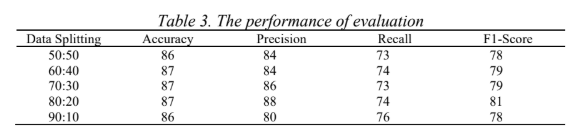

## Try default parameter here in case the result from genetic algorithm is not well optimized

In [113]:
lgbm_model_default = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', lgb.LGBMClassifier(
        objective='binary',
        random_state=42,
        verbose=0))
])

lgbm_model_default.fit(X_train_scaled, y_train)

y_pred_lgbm = lgbm_model_default.predict(X_test_scaled)

accuracy_lgbm = accuracy_score(y_pred_lgbm, y_test)
print ("LightGBM - Accuracy (Test Set):", accuracy_lgbm)

LightGBM - Accuracy (Test Set): 0.8780120481927711


In [114]:
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       427
           1       0.89      0.93      0.91       901

    accuracy                           0.88      1328
   macro avg       0.87      0.85      0.86      1328
weighted avg       0.88      0.88      0.88      1328



# Catboost

## Genetic Algorithm

In [92]:
# Define the fitness function
def evaluate_catboost(individual):
    params = {
        'depth': int(individual[0]),
        'learning_rate': max(individual[1], 0.001),
        'iterations': int(individual[2]),
        'l2_leaf_reg': max(individual[3], 1),
        'bagging_temperature': max(individual[4], 0),
        'random_strength': max(individual[5], 1e-9),
        'loss_function': 'Logloss',
        'random_state': 42,
        'verbose': 0
    }

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', CatBoostClassifier(**params))
    ])

    scores = cross_val_score(
        pipeline,
        X_train_scaled,
        y_train,
        cv=3,
        scoring='accuracy'
    )
    return (np.mean(scores),)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_depth", random.randint, 3, 10)
toolbox.register("attr_learning_rate", random.uniform, 0.01, 0.3)
toolbox.register("attr_iterations", random.randint, 50, 200)
toolbox.register("attr_l2_leaf_reg", random.uniform, 1, 10)
toolbox.register("attr_bagging_temp", random.uniform, 0, 1)
toolbox.register("attr_random_strength", random.uniform, 1e-9, 1.0)

toolbox.register("individual", tools.initCycle, creator.Individual, (
    toolbox.attr_depth,
    toolbox.attr_learning_rate,
    toolbox.attr_iterations,
    toolbox.attr_l2_leaf_reg,
    toolbox.attr_bagging_temp,
    toolbox.attr_random_strength
), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_catboost)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [93]:
population = toolbox.population(n=20)
hof = tools.HallOfFame(3)  # Save top 3 individuals
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

result, logbook = algorithms.eaSimple(
    population, toolbox,
    cxpb=0.7, mutpb=0.2,
    ngen=10,
    stats=stats,
    halloffame=hof,
    verbose=True
)

# Get best parameters
best_params = {
    'depth': int(hof[0][0]),
    'learning_rate': hof[0][1],
    'iterations': int(hof[0][2]),
    'l2_leaf_reg': hof[0][3],
    'bagging_temperature': hof[0][4],
    'random_strength': hof[0][5],
    'loss_function': 'Logloss',
    'random_state': 42,
    'verbose': 0
}

gen	nevals	avg     	min     	max     
0  	20    	0.866877	0.853359	0.874031
1  	15    	0.867975	0.839793	0.872416
2  	12    	0.870058	0.860142	0.873062
3  	17    	0.871027	0.865633	0.873708
4  	10    	0.871399	0.867571	0.873708
5  	18    	0.8703  	0.836563	0.875323
6  	16    	0.870284	0.856589	0.874354
7  	13    	0.871108	0.864018	0.874354
8  	19    	0.870882	0.864664	0.874354
9  	17    	0.870914	0.86531 	0.874354
10 	18    	0.869767	0.865633	0.874354


In [94]:
print("Best Parameters:", best_params)

Best Parameters: {'depth': 4, 'learning_rate': 0.23069327139658863, 'iterations': 128, 'l2_leaf_reg': 5.894110329124391, 'bagging_temperature': 0.7516619837235651, 'random_strength': 0.7140430042054948, 'loss_function': 'Logloss', 'random_state': 42, 'verbose': 0}


In [95]:
best_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', CatBoostClassifier(**best_params))
])
best_model.fit(X_train_scaled, y_train)
print(classification_report(y_test, best_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       427
           1       0.89      0.93      0.91       901

    accuracy                           0.87      1328
   macro avg       0.86      0.84      0.85      1328
weighted avg       0.87      0.87      0.87      1328



## Store the best hyperparameter (so far) here

In [96]:
# Use this for the report

params_catb = {'depth': 8,
               'learning_rate': 0.08948885931652993,
               'iterations': 178,
               'l2_leaf_reg': 9.289183283112662,
               'bagging_temperature': 0.4350362114521534,
               'random_strength': 0.48212689688891097,
               'loss_function': 'Logloss',
               'random_state': 42,
               'verbose': 0}

cat_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', CatBoostClassifier(**params_catb))
])

cat_model.fit(X_train_scaled, y_train)

cat_y_pred_train = cat_model.predict(X_train_scaled)
cat_y_pred = cat_model.predict(X_test_scaled)

accuracy_cat = accuracy_score(y_test, cat_y_pred)
print("CatBoost - Accuracy (Test Set):", accuracy_cat)

CatBoost - Accuracy (Test Set): 0.8727409638554217


In [97]:
print(classification_report(y_test, cat_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       427
           1       0.89      0.93      0.91       901

    accuracy                           0.87      1328
   macro avg       0.86      0.84      0.85      1328
weighted avg       0.87      0.87      0.87      1328



Compare the metrics from label '0' (Dropout) with the previous paper result below

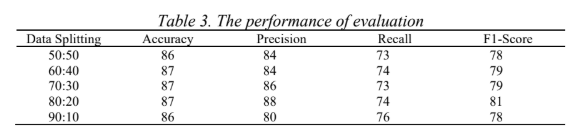

## Try default parameter here in case the result from genetic algorithm is not well optimized

In [115]:
cat_model_default = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', CatBoostClassifier(
        loss_function='Logloss',
        random_state=42,
        verbose=100,
        early_stopping_rounds=50))
])

cat_model_default.fit(X_train_scaled, y_train)

cat_y_pred_train = cat_model_default.predict(X_train_scaled)
cat_y_pred = cat_model_default.predict(X_test_scaled)

accuracy_cat = accuracy_score(y_test, cat_y_pred)
print("CatBoost - Accuracy (Test Set):", accuracy_cat)

Learning rate set to 0.019021
0:	learn: 0.6783969	total: 10.5ms	remaining: 10.4s
100:	learn: 0.3123473	total: 835ms	remaining: 7.43s
200:	learn: 0.2570448	total: 1.68s	remaining: 6.69s
300:	learn: 0.2241680	total: 2.53s	remaining: 5.87s
400:	learn: 0.1994027	total: 3.38s	remaining: 5.04s
500:	learn: 0.1773790	total: 4.25s	remaining: 4.23s
600:	learn: 0.1586285	total: 6.27s	remaining: 4.16s
700:	learn: 0.1430240	total: 7.59s	remaining: 3.24s
800:	learn: 0.1297176	total: 8.45s	remaining: 2.1s
900:	learn: 0.1180837	total: 9.3s	remaining: 1.02s
999:	learn: 0.1080136	total: 10.1s	remaining: 0us
CatBoost - Accuracy (Test Set): 0.8757530120481928


In [117]:
print(classification_report(y_test, cat_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       427
           1       0.89      0.93      0.91       901

    accuracy                           0.88      1328
   macro avg       0.86      0.85      0.85      1328
weighted avg       0.87      0.88      0.87      1328

